# Video Game Hit Predictor (Pre-processed Data)

## 1. Setup and Loading
We are using a dataset that is already One-Hot Encoded and Scaled.
* **Input:** `cleaned_dataset.csv`
* **Target:** `Is_hit`
* **Leakage:** We must drop `Global_Sales`.

In [82]:
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
# Dummy
from sklearn.dummy import DummyClassifier


27027.56s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


## 2. Data Preparation
Since the data is already cleaned, we skip OneHotEncoding.
We focus on defining X (Features) and y (Target).

In [83]:
# Load Data
df = pd.read_csv("cleaned_dataset.csv")

# DROP Global_Sales because it reveals the answer
X = df.drop(columns=['Global_Sales', 'Is_hit']) ## Features that acts as clues for the model
y = df['Is_hit']                     ## Target variable

# Check shapes
print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")

Features shape: (16540, 35)
Target distribution:
Is_hit
0    0.900242
1    0.099758
Name: proportion, dtype: float64


## 3. Train/Test Split (90/10)
We use `stratify=y` to keep the Hit/Flop ratio consistent.

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.1, 
    stratify=y,           # maintain the same proportion of classes in train and test sets 1/9 hit/flops
    random_state=1        # a seed for reproducibility
)

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Train size: 14886
Test size: 1654


## 4. Model Training
We train three models. Crucially, we use **Class Weights** to handle the imbalance.

* **Logistic Regression:** `class_weight='balanced'`
* **Random Forest:** `class_weight='balanced'`
* **XGBoost:** `scale_pos_weight` (calculated manually)

In [ ]:

scale_pos_weight = 9   # scaling the count(flops) / count(hit)

models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced',    # Ensures that the sampling process for building each tree is weighted towards the minority class (Hits)
        max_iter=10000, 
        random_state=1  # a seed for reproducibility
    ),
    
    "Random Forest": RandomForestClassifier(
        # Hyperparameters chosen to increase complexity and robustness
        n_estimators=300, 
        max_depth=12,   # Limits the maximum depth of each individual tree
        min_samples_leaf=5, # Requires that 5 samples must be present in a leaf node for a split to be considered
        class_weight='balanced', # Ensures that the sampling process for building each tree is weighted towards the minority class (Hits)
        random_state=1  # a seed for reproducibility
    ),
    
    "XGBoost": XGBClassifier(
        # Hyperparameters chosen to enable deep learning and prevent overfitting
        scale_pos_weight=scale_pos_weight, # If the machine predicts wrongly "hit" it gets 9 times more penalized than if it wrongly predicts "flop" it has the same effect of class_weight='balanced' in sklearn
        n_estimators=500,   # Increased from the default to compensate for the reduced learning_rate
        max_depth=7,    # Sets a reasonable depth for complex models
        learning_rate=0.1,  # A smaller learning rate forces the model to learn more slowly and carefully
        subsample=0.8,  # Introduces randomness, use 80% of the data
        colsample_bytree=0.8, # Introduces randomness, use 80% of the features(columns)
        eval_metric='logloss', 
        random_state=1  # a seed for reproducibility
    )
}

trained_models = {}

# Training Loop
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"Done.")

Training Logistic Regression...
Done.
Training Random Forest...
Done.
Training XGBoost...
Done.


## 5. Model Evaluation
We evaluate using Precision, Recall, and ROC-AUC. 
* **Recall** is vital here: We want to catch as many Hits as possible.


--- Logistic Regression Results ---


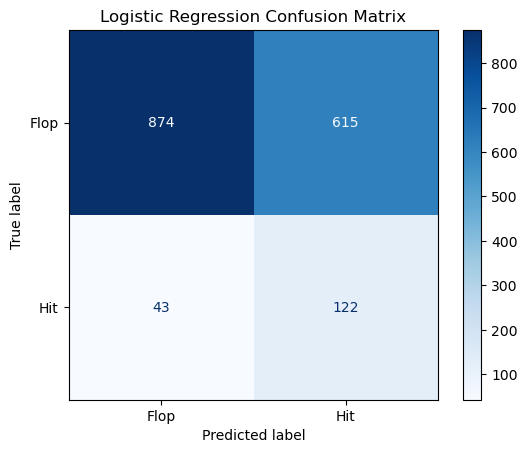


--- Random Forest Results ---


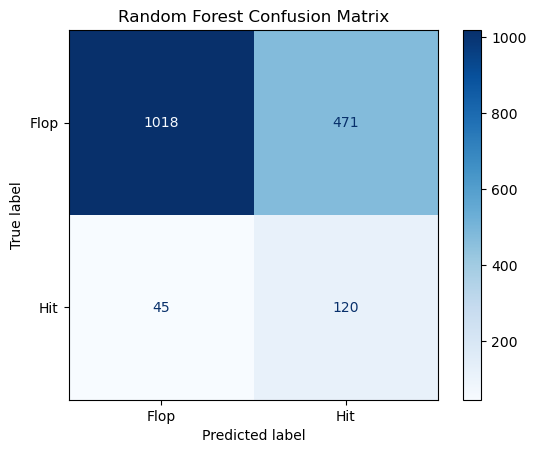


--- XGBoost Results ---


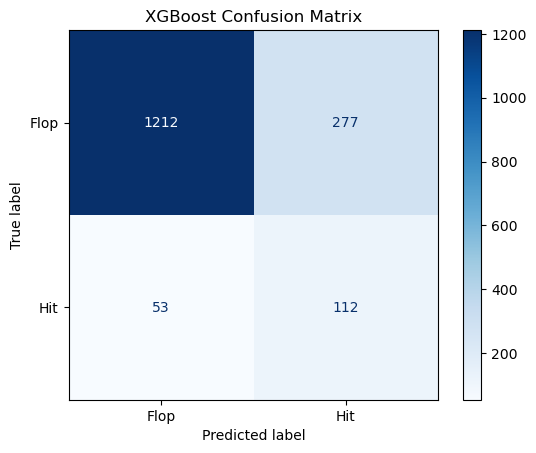

,Model,ROC AUC,Hit Precision,Hit Recall,Hit F1-Score,Flop Recall,Overall F1-Score (Weighted),Accuracy,Flop Precision,Flop F1-Score
3,XGBoost,0.825054,0.287918,0.678788,0.404332,0.813969,0.832705,0.800484,0.958103,0.880174
2,Random Forest,0.780833,0.203046,0.727273,0.317460,0.683680,0.749887,0.688029,0.957667,0.797806
1,Logistic Regression,0.718644,0.165536,0.739394,0.270510,0.586971,0.681027,0.602177,0.953108,0.726517
0,Dummy (Always Flop) 🛑,0.500000,0.000000,0.000000,0.000000,1.000000,0.852981,0.900242,0.900242,0.947502


In [94]:
results = []

# --- 1. Evaluate Dummy Model (Always Flop) ---
# The dummy model always predicts class 0 (Flop).
y_dummy_pred = np.zeros(len(y_test), dtype=int)
# The probability of being a Hit (class 1) is always 0.
y_dummy_proba = np.zeros(len(y_test)) 

# Calculate metrics for the dummy baseline
dummy_roc = roc_auc_score(y_test, y_dummy_proba)
dummy_report = classification_report(y_test, y_dummy_pred, output_dict=True, zero_division=0)

results.append({
    "Model": "Dummy (Always Flop) 🛑",
    "ROC AUC": dummy_roc,
    "Hit Precision": dummy_report['1']['precision'],
    "Hit Recall": dummy_report['1']['recall'],
    "Hit F1-Score": dummy_report['1']['f1-score'],
    "Flop Recall": dummy_report['0']['recall'],
    "Overall F1-Score (Weighted)": dummy_report['weighted avg']['f1-score'],
    "Accuracy": dummy_report['accuracy'],
    "Flop Precision": dummy_report['0']['precision'],
    "Flop F1-Score": dummy_report['0']['f1-score']

})



# --- 2. Evaluate Trained Models ---
for name, model in trained_models.items():
    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate Scores
    roc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0) 

    results.append({
        # Crucial Metrics
        "Model": name,
        "ROC AUC": roc,                             
        "Hit Precision": report['1']['precision'],  
        "Hit Recall": report['1']['recall'],       
        "Hit F1-Score": report['1']['f1-score'],     # Most important metric
        "Flop Recall": report['0']['recall'],       
        "Overall F1-Score (Weighted)": report['weighted avg']['f1-score'],     

        
        # Useless metric, but included for completeness
        "Accuracy": report['accuracy'],
        "Flop Precision": report['0']['precision'],
        "Flop F1-Score": report['0']['f1-score']

    })
    
    # Plot Confusion Matrix
    print(f"\n--- {name} Results ---")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Flop", "Hit"])
    disp.plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

# Show Comparison Table
results_df = pd.DataFrame(results).sort_values("Hit F1-Score", ascending=False)
display(results_df)

## 6. Inference Example (Prediction)
Take a sample from our test set to see how the model decides.

In [90]:
# Pick a random game from the test set
sample_idx = np.random.choice(X_test.index)
sample_game = X_test.loc[[sample_idx]]
actual_label = y_test.loc[sample_idx]

print("--- Game Features (Processed) ---")
# Show which Genre/Platform is active (has a 1)
for col in sample_game.columns:
    if sample_game[col].values[0] > 0 and 'Genre' in col:
        print(f"Genre: {col.replace('Genre_', '')}")
    if sample_game[col].values[0] > 0 and 'Platform' in col:
        print(f"Platform: {col.replace('Platform_', '')}")

print(f"\nActual Result: {'HIT' if actual_label==1 else 'FLOP'}")

# Predict with XGBoost
pred = trained_models['XGBoost'].predict(sample_game)[0]
prob = trained_models['XGBoost'].predict_proba(sample_game)[0][1]

print(f"Model Prediction: {'HIT' if pred==1 else 'FLOP'}")
print(f"Hit Probability: {prob:.4f}")

--- Game Features (Processed) ---
Genre: Sports
Platform: PS

Actual Result: FLOP
Model Prediction: FLOP
Hit Probability: 0.0108
